# Imports and Setup

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator

import getdist
from getdist import plots, loadMCSamples

from plot_style import style_dict
from theory_models import (
    add_concave_convex_divide, add_concave_convex_labels,
    add_polynomial_potentials, add_efold_shading, add_alpha_unity_model_markers
)
from legend_utils import create_dummy_plot_elements_for_legend, add_model_handlers_to_legend

# Load in Data, Create Forecast

In [2]:
chain_files = {
    "SPA_BK": "chains/SPA_BK/CLASS",
    "SPA_BK_DESI": "chains/SPA_BK_DESI/CLASS",
}

chains = {}
bf_dicts = {}
for key, value in chain_files.items():
    chains[key] = loadMCSamples(value, settings={"ignore_rows": 0.2})
    bf_dicts[key] = chains[key].getParamBestFitDict()


In [3]:
# Create forecast chains preserving r-ns correlation from real data
cov = chains["SPA_BK"].cov(["r", "n_s"])
corr = cov / np.sqrt(np.outer(np.diag(cov), np.diag(cov)))
cov_scaled = np.diag([1e-3, 2e-3]) @ corr @ np.diag([1e-3, 2e-3])

mrg = chains["SPA_BK"].getMargeStats()
chains["FC"] = getdist.gaussian_mixtures.GaussianND([3e-3, mrg.parWithName("n_s").mean],
                                                    cov_scaled,
                                                    names=["r", "n_s"])

mrg_desi = chains["SPA_BK_DESI"].getMargeStats()
chains["FC_DESI"] = getdist.gaussian_mixtures.GaussianND([3e-3, mrg_desi.parWithName("n_s").mean],
                                                         cov_scaled,
                                                         names=["r", "n_s"])

# Simple, Clean Plot

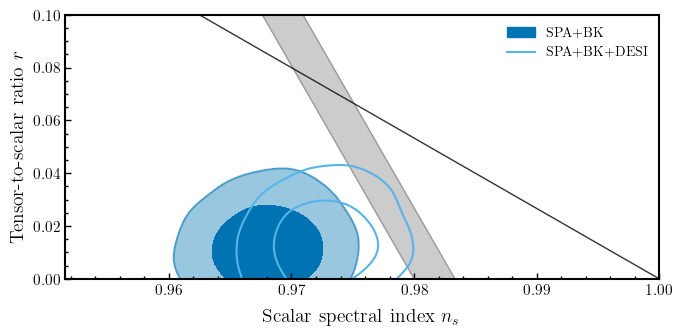

In [4]:
plt.close()

g = plots.get_single_plotter(width_inch=2.0*3.464, ratio=0.5)
g.settings.legend_frame = False
ax = plt.gca()

# Data constraints
all_dat = ["SPA_BK", "SPA_BK_DESI"]
g.plot_2d([chains[dat] for dat in all_dat],
          ["ns", "r"],
          colors=[style_dict[dat]["colour"] for dat in all_dat],
          ls=[style_dict[dat]["ls"] for dat in all_dat],
          lws=[style_dict[dat]["lw"] for dat in all_dat],
          filled=[style_dict[dat]["filled"] for dat in all_dat])

# Add theory elements
add_efold_shading(ax, N_range=(50, 60), ns_range=(0.96, 1.0))
add_concave_convex_divide(ax, ns_range=(0.96, 1.0))

# Legend
g.add_legend(["SPA+BK", "SPA+BK+DESI"], fontsize=10)

# Axis setup
ax.set_ylim((0, 0.1))
ax.set_xlim((0.9515, 1.0))
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.set_ylabel("Tensor-to-scalar ratio $r$")
ax.set_xlabel("Scalar spectral index $n_s$")

plt.tight_layout()
plt.show()

# Paper Plots

## Data Plot

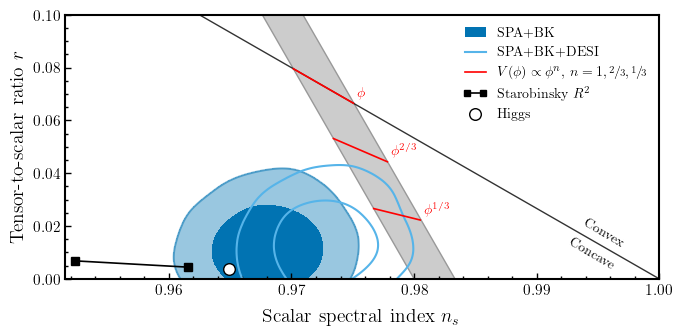

In [5]:
# Cell: Data Plot (Paper version)

plt.close()

g = plots.get_single_plotter(width_inch=2.0*3.464, ratio=0.5)
ax = plt.gca()

# Data constraints
all_dat = ["SPA_BK", "SPA_BK_DESI"]
g.plot_2d([chains[dat] for dat in all_dat],
          ["ns", "r"],
          colors=[style_dict[dat]["colour"] for dat in all_dat],
          ls=[style_dict[dat]["ls"] for dat in all_dat],
          lws=[style_dict[dat]["lw"] for dat in all_dat],
          filled=[style_dict[dat]["filled"] for dat in all_dat])
create_dummy_plot_elements_for_legend(all_dat)

# Theory elements
add_concave_convex_divide(ax, ns_range=(0.9, 1.1))
add_polynomial_potentials(ax, p_values=[1/3, 2/3, 1], N_range=(50, 60),
                          label_offsets={"1/3": [0.00025, 0.0025],
                                        "2/3": [0.00025, 0.0025],
                                        "": [0.00025, 0.0025]})
add_efold_shading(ax, N_range=(50, 60), ns_range=(0.96, 1.0))
add_alpha_unity_model_markers(ax, models=["Starobinsky $R^2$", "Higgs"])
add_concave_convex_labels(ax)

# Legend - automatically handles Starobinsky's special display
add_model_handlers_to_legend(ax, loc="upper right", ncol=1, fontsize=10, handlelength=1.5)

# Axis setup
ax.set_ylim((0, 0.1))
ax.set_xlim((0.9515, 1.0))
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.set_ylabel("Tensor-to-scalar ratio $r$")
ax.set_xlabel("Scalar spectral index $n_s$")

plt.tight_layout()
plt.show()

## Forecast Plot

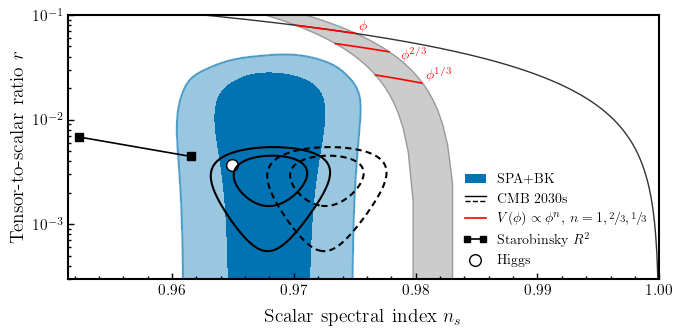

In [6]:
# Cell: Forecast Plot

plt.close()

g = plots.get_single_plotter(width_inch=2.0*3.464, ratio=0.5)
ax = plt.gca()

# Data constraints
all_dat = ["SPA_BK", "FC", "FC_DESI"]
g.plot_2d([chains[dat] for dat in all_dat],
          ["ns", "r"],
          colors=[style_dict[dat]["colour"] for dat in all_dat],
          ls=[style_dict[dat]["ls"] for dat in all_dat],
          lws=[style_dict[dat]["lw"] for dat in all_dat],
          filled=[style_dict[dat]["filled"] for dat in all_dat])
legend_handles, legend_labels, handler_map = create_dummy_plot_elements_for_legend(all_dat, True)

# Theory elements (optimized for log scale)
add_concave_convex_divide(ax, ns_range=(0.9, 1.1))
poly_handle, poly_label = add_polynomial_potentials(
    ax, p_values=[1/3, 2/3, 1], N_range=(50, 60),
    label_offsets={"1/3": [0.00025, 0.0025],
                   "2/3": [4*0.00025, -2.5*0.0025],
                   "": [0.00025, 2*0.0025]},
    return_handles=True)
legend_handles.append(poly_handle)
legend_labels.append(poly_label)

add_efold_shading(ax, N_range=(50, 60), ns_range=(0.96, 1.0))

model_handles, model_labels = add_alpha_unity_model_markers(ax, return_handles=True)
legend_handles.extend(model_handles)
legend_labels.extend(model_labels)

# Legend - automatically adds Starobinsky handler to existing handler_map
add_model_handlers_to_legend(ax, handles=legend_handles, labels=legend_labels,
                             handler_map=handler_map, loc="lower right",
                             ncol=1, fontsize=10, handlelength=1.5)

# Axis setup (log scale)
ax.set_ylim((3e-4, 1e-1))
ax.set_xlim((0.9515, 1.0))
ax.set_yscale("log")
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.set_ylabel("Tensor-to-scalar ratio $r$")
ax.set_xlabel("Scalar spectral index $n_s$")

plt.tight_layout()
plt.show()